# Dogs vs Cats

https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition

In [1]:
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV3Small

print(tf.__version__)
print(tf.executing_eagerly())
print(tf.config.list_physical_devices('GPU'))

2.8.0
True
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Функции загрузки данных

In [2]:
import os
from random import shuffle
from glob import glob

IMG_SIZE = (224, 224)  # размер входного изображения сети

train_files = glob('data/train/*.jpg')
test_files = glob('data/test/*.jpg')

# загружаем входное изображение и предобрабатываем
def load_image(path, target_size=IMG_SIZE):
    img = cv2.imread(path)[...,::-1]
    img = cv2.resize(img, target_size)
    return tf.keras.applications.mobilenet_v3.preprocess_input(img)  # предобработка для MobileNet

# функция-генератор загрузки обучающих данных с диска
def fit_generator(files, batch_size=32):
    batch_size = min(batch_size, len(files))
    while True:
        shuffle(files)
        for k in range(len(files) // batch_size):
            i = k * batch_size
            j = i + batch_size
            if j > len(files):
                j = - j % len(files)
            x = np.array([load_image(path) for path in files[i:j]])
            y = np.array([1. if os.path.basename(path).startswith('dog') else 0.
                          for path in files[i:j]])
            yield (x, y)

# функция-генератор загрузки тестовых изображений с диска
def predict_generator(files):
    while True:
        for path in files:
            yield np.array([load_image(path)])

## Визуализируем примеры для обучения

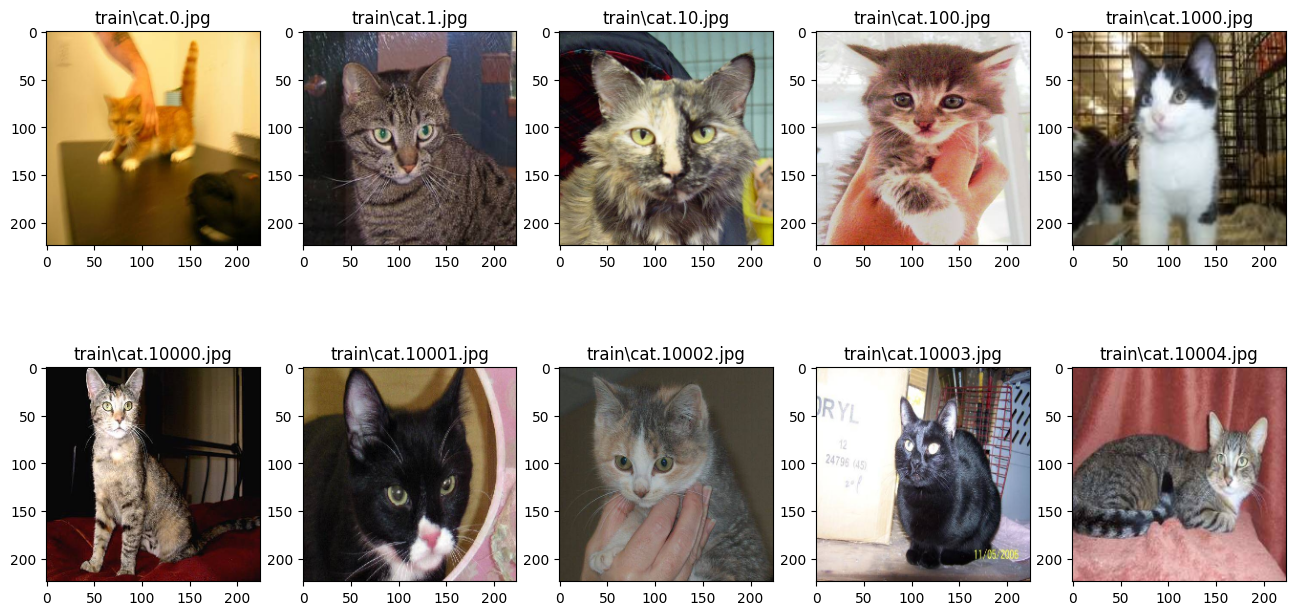

In [3]:
%matplotlib inline
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(16, 8))
for i, path in enumerate(train_files[:10], 1):
    subplot = fig.add_subplot(2, 5, i)
    subplot.set_title('%s' % path.split('/')[-1])
    img = cv2.imread(path)[...,::-1]
    img = cv2.resize(img, IMG_SIZE)
    plt.imshow(img)

## Загружаем предобученную модель

In [4]:
# base_model - объект класса keras.models.Model (Functional Model)
base_model = MobileNetV3Small(weights='imagenet',
                              include_top=False,
                              input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))

In [5]:
base_model.summary()

Model: "MobilenetV3small"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 Conv (Conv2D)                  (None, 112, 112, 16  432         ['rescaling[0][0]']              
                                )                                                                 
                                                                                   

## Добавляем полносвязный слой

In [6]:
# фиксируем все веса предобученной сети
for layer in base_model.layers:
    layer.trainable = False

x = base_model.layers[-2].output
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(1,  # один выход (бинарная классификация)
                          activation='sigmoid',  # функция активации  
                          kernel_regularizer=tf.keras.regularizers.l1(1e-4))(x)

model = tf.keras.Model(inputs=base_model.input, outputs=x, name='dogs_vs_cats')

## Выводим архитектуру модели

In [7]:
model.summary()

Model: "dogs_vs_cats"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 Conv (Conv2D)                  (None, 112, 112, 16  432         ['rescaling[0][0]']              
                                )                                                                 
                                                                                       

## Компилируем модель и запускаем обучение

In [8]:
model.compile(optimizer='adam', 
              loss='binary_crossentropy',  # функция потерь binary_crossentropy (log loss
              metrics=['accuracy'])

In [9]:
val_samples = 10  # число изображений в валидационной выборке

shuffle(train_files)  # перемешиваем обучающую выборку
validation_data = next(fit_generator(train_files[:val_samples], val_samples))
train_data = fit_generator(train_files[val_samples:])  # данные читаем функцией-генератором

# запускаем процесс обучения
model.fit(train_data,
          steps_per_epoch=10,  # число вызовов генератора за эпоху
          epochs=100,  # число эпох обучения
          validation_data=validation_data)

Epoch 1/100
10/10 [==============================] - 7s 233ms/step - loss: 0.5916 - accuracy: 0.7563 - val_loss: 0.1084 - val_accuracy: 1.0000
Epoch 2/100
10/10 [==============================] - 1s 105ms/step - loss: 0.2217 - accuracy: 0.9281 - val_loss: 0.0686 - val_accuracy: 1.0000
Epoch 3/100
10/10 [==============================] - 1s 104ms/step - loss: 0.1700 - accuracy: 0.9469 - val_loss: 0.0558 - val_accuracy: 1.0000
Epoch 4/100
10/10 [==============================] - 1s 104ms/step - loss: 0.1441 - accuracy: 0.9594 - val_loss: 0.0341 - val_accuracy: 1.0000
Epoch 5/100
10/10 [==============================] - 1s 102ms/step - loss: 0.1539 - accuracy: 0.9500 - val_loss: 0.0416 - val_accuracy: 1.0000
Epoch 6/100
10/10 [==============================] - 1s 99ms/step - loss: 0.1989 - accuracy: 0.9219 - val_loss: 0.0382 - val_accuracy: 1.0000
Epoch 7/100
10/10 [==============================] - 1s 106ms/step - loss: 0.1452 - accuracy: 0.9500 - val_loss: 0.0309 - val_accuracy: 1.0000


In [14]:
model.save('cats-dogs-mobilenet.hdf5')

## Предсказания на проверочной выборке

In [11]:
test_pred = model.predict(
    predict_generator(test_files), steps=len(test_files))

C:\Users\fight\AppData\Local\Temp\ipykernel_4236\2648597163.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  subplot.set_title('%.2f %s' % (score, os.path.basename(path)))


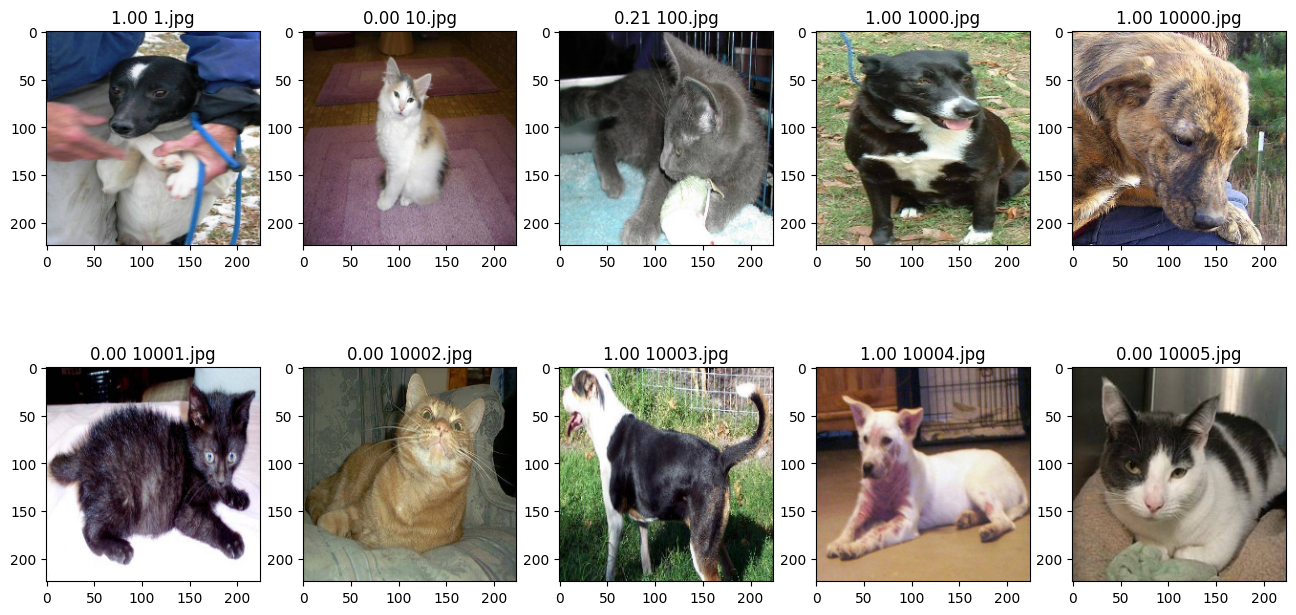

In [12]:
fig = plt.figure(figsize=(16, 8))
for i, (path, score) in enumerate(zip(test_files[:10], test_pred[:10]), 1):
    subplot = fig.add_subplot(2, 5, i)
    subplot.set_title('%.2f %s' % (score, os.path.basename(path)))
    img = cv2.imread(path)[...,::-1]
    img = cv2.resize(img, IMG_SIZE)
    subplot.imshow(img)

## Готовим данные для отправки

In [13]:
import re

with open('submit.csv', 'w') as dst:
    dst.write('id,label\n')
    for path, score in zip(test_files, test_pred):
        dst.write('%s,%f\n' % (re.search('(\d+).jpg$', path).group(1), score))

C:\Users\fight\AppData\Local\Temp\ipykernel_4236\2367134345.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dst.write('%s,%f\n' % (re.search('(\d+).jpg$', path).group(1), score))


In [ ]:
# LogLoss = 1.04979